# Проект: Оптимизация выручки интернет-магазина через приоритизацию гипотез и анализ A/B-тестирования

**Описание проекта**

Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.

Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты.

**Цель проекта**

Повысить выручку интернет-магазина путем определения и тестирования наиболее перспективных гипотез, а затем анализа их влияния на ключевые метрики бизнеса с помощью A/B-тестирования.

**Ход исследования**

1. Приоритизировать гипотезы, чтобы выбрать те, которые обладают наибольшим потенциалом для роста.
2. Провести и проанализировать A/B-тест, чтобы объективно оценить влияние внедренных гипотез на показатели выручки, выявить успешные изменения и принять обоснованное решение о дальнейших шагах.

**Описание данных**

**Данные для первой части**

Файл `/datasets/hypothesis.csv`.

- `Hypothesis` — краткое описание гипотезы;
- `Reach` — охват пользователей по 10-балльной шкале;
- `Impact` — влияние на пользователей по 10-балльной шкале;
- `Confidence` — уверенность в гипотезе по 10-балльной шкале;
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение `Efforts`, тем дороже проверка гипотезы.

**Данные для второй части**

Файл `/datasets/orders.csv`.
- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ.

Файл `/datasets/visitors.csv`.

- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

## Подготовка данных

In [ ]:
# Импоритруем необходимые библиотеки
import pandas as pd
import numpy as np
import datetime as dt
import scipy.stats as stats
from matplotlib import pyplot as plt

In [ ]:
# Загружаем данные
try:
    hypothesis, orders, visitors = (
        pd.read_csv('/datasets/hypothesis.csv'),
        pd.read_csv('/datasets/orders.csv'),
        pd.read_csv('/datasets/visitors.csv')
)

except:
    hypothesis, orders, visitors = (
        pd.read_csv('datasets/hypothesis.csv'),
        pd.read_csv('datasets/orders.csv'),
        pd.read_csv('datasets/visitors.csv')
)

In [ ]:
# Выведем первые строки датафреймов и информацию о них
# Датафрейм hypothesis
hypothesis.info()
hypothesis.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


In [ ]:
# Датафрейм orders
orders.info()
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [ ]:
# Оценим столбцы с числовым типом данных orders
orders.describe()

,transactionId,visitorId,revenue
count,1.197000e+03,1.197000e+03,1.197000e+03
mean,2.155621e+09,2.165960e+09,8.348006e+03
std,1.229085e+09,1.236014e+09,3.919113e+04
min,1.062393e+06,5.114589e+06,5.000000e+01
25%,1.166776e+09,1.111826e+09,1.220000e+03
50%,2.145194e+09,2.217985e+09,2.978000e+03
75%,3.237740e+09,3.177606e+09,8.290000e+03
max,4.293856e+09,4.283872e+09,1.294500e+06


In [ ]:
# Найдём за какой период нам предоставлены данные
print(orders['date'].min())
print(orders['date'].max())

2019-08-01
2019-08-31


In [ ]:
# Датафрейм visitors
visitors.info()
visitors.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [ ]:
# Оценим столбцы с числовым типом данных visitors
visitors.describe()

,visitors
count,62.000000
mean,607.290323
std,114.400560
min,361.000000
25%,534.000000
50%,624.500000
75%,710.500000
max,770.000000


In [ ]:
# Найдём за какой период нам предоставлены данные
print(visitors['date'].min())
print(visitors['date'].max())

2019-08-01
2019-08-31


In [ ]:
# Приведём названия столбцов датафреймов к нижнему регистру
# и к стилю написания `snake_case`
hypothesis.columns = hypothesis.columns.str.lower()

orders = orders.rename(
    columns={
        'transactionId':'transaction_id',
        'visitorId':'visitor_id'
    }
)

In [ ]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [ ]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   transaction_id  1197 non-null   int64 
 1   visitor_id      1197 non-null   int64 
 2   date            1197 non-null   object
 3   revenue         1197 non-null   int64 
 4   group           1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [ ]:
# Изменим тип данных столбцов с датами у датафреймов `orders` и `visitors`
# на datetime.
orders["date"] = orders["date"].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)
visitors["date"] = visitors["date"].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

In [ ]:
# Проверим датафреймы на пропуски и дубликаты
dataframes = {'hypothesis': hypothesis, 'orders': orders, 'visitors': visitors}

for name, df in dataframes.items():
    print(f'{name}:')
    print(f'  Кол-во пропусков:\n{df.isna().sum()}\n')
    print(f'  Кол-во дубликатов: {df.duplicated().sum()}\n')

hypothesis:
  Кол-во пропусков:
hypothesis    0
reach         0
impact        0
confidence    0
efforts       0
dtype: int64

  Кол-во дубликатов: 0

orders:
  Кол-во пропусков:
transaction_id    0
visitor_id        0
date              0
revenue           0
group             0
dtype: int64

  Кол-во дубликатов: 0

visitors:
  Кол-во пропусков:
date        0
group       0
visitors    0
dtype: int64

  Кол-во дубликатов: 0



In [ ]:
print("Количество уникальных посетителей:", orders['visitor_id'].nunique())

Количество уникальных посетителей: 1031


In [ ]:
# Проверим корректность разбиения пользователей на группы

# Шаг 1: Найдем пользователей, которые попали в обе группы
users_in_both_groups = (
    orders.groupby('visitor_id')['group']
    .nunique()  # количество уникальных значений в столбце group для каждого visitor_id
    .reset_index()
)
users_in_both_groups = users_in_both_groups[users_in_both_groups['group'] > 1]['visitor_id']

# Шаг 2: Фильтруем исходный датафрейм, удаляя записи пользователей из обеих групп
orders = orders[~orders['visitor_id'].isin(users_in_both_groups)]

# Теперь датафрейм `orders` перезаписан, и в нем нет пользователей, которые попали и в группу A, и в группу B.


In [ ]:
print("Количество пользователей в обеих группах:", len(users_in_both_groups))

Количество пользователей в обеих группах: 58


В данных обнаружена небольшая доля пользователей — 58 (5,6%) попавших в обе группы. Таки епользователи могут нарушить чистоту эксперимента и исказить результаты, поскольку они получают два разных воздействия теста. Исключим их из анализа.

**Вывод:**<br/>
- Загружены и проверены три датафрейма hypothesis, orders, visitors
- Названия столбцов датафреймов приведены к стилю написания snake_case
- Тип данных столбцов с датами приведён к datetime.
- Предоставлены данные за период 01.08.2019 - 31.08.2019
- Пропусков и дубликатов не обнаружено
- Обнаружены и удалены пользователи, которые попали в обе группы.

## Часть 1. Приоритизация гипотез

### Применим фреймворк ICE для приоритизации гипотез

Применим фреймворк `ICE` для приоритизации гипотез. Отсортируем их по убыванию приоритета.

Фреймворк `ICE SCORE` расчитывается как произведение параметров `Impact` (Влияние изменения метрики на пользователей) и `Confidence` (Уровень уверенности в том, что гипотеза действительно даст заявленный результат), деленное на `Efforts` (Усилия необходимые для реализации гипотезы).

In [ ]:
pd.options.display.max_colwidth = 20

hypothesis['ICE'] = (hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']

print(hypothesis[['hypothesis', 'ICE']].sort_values('ICE', ascending=False))

            hypothesis        ICE
8  Запустить акцию,...  16.200000
0  Добавить два нов...  13.333333
7  Добавить форму п...  11.200000
6  Показать на глав...   8.000000
2  Добавить блоки р...   7.000000
1  Запустить собств...   2.000000
5  Добавить страниц...   1.333333
3  Изменить структу...   1.125000
4  Изменить цвет фо...   1.000000


In [ ]:
print(hypothesis[['hypothesis', 'impact', 'confidence', 'efforts', 'ICE']].sort_values('ICE', ascending=False))

            hypothesis  impact  confidence  efforts        ICE
8  Запустить акцию,...       9           9        5  16.200000
0  Добавить два нов...      10           8        6  13.333333
7  Добавить форму п...       7           8        5  11.200000
6  Показать на глав...       3           8        3   8.000000
2  Добавить блоки р...       3           7        3   7.000000
1  Запустить собств...       5           4       10   2.000000
5  Добавить страниц...       2           2        3   1.333333
3  Изменить структу...       3           3        8   1.125000
4  Изменить цвет фо...       1           1        1   1.000000


Наиболее перспективные гипотезы по ICE: 8, 0, 7

### Применим фреймворк RICE для приоритизации гипотез

Применим фреймворк `RICE` для приоритизации гипотез. Отсортируем их по убыванию приоритета.

Фреймворк `RICE SCORE` расчитывается как произведение параметров `Reach` (Cкольких пользователей затронет изменение), `Impact` (Влияние изменения метрики на пользователей) и `Confidence` (Уровень уверенности в том, что гипотеза действительно даст заявленный результат), деленное на `Efforts` (Усилия необходимые для реализации гипотезы).

In [ ]:
hypothesis['RICE'] = (
    hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']
) / hypothesis['efforts']

print(hypothesis[['hypothesis', 'RICE']].sort_values('RICE', ascending=False))

            hypothesis   RICE
7  Добавить форму п...  112.0
2  Добавить блоки р...   56.0
0  Добавить два нов...   40.0
6  Показать на глав...   40.0
8  Запустить акцию,...   16.2
3  Изменить структу...    9.0
1  Запустить собств...    4.0
5  Добавить страниц...    4.0
4  Изменить цвет фо...    3.0


In [ ]:
print(hypothesis[['hypothesis', 'reach', 'impact', 'confidence', 'efforts', 'RICE']].sort_values('RICE', ascending=False))

            hypothesis  reach  impact  confidence  efforts   RICE
7  Добавить форму п...     10       7           8        5  112.0
2  Добавить блоки р...      8       3           7        3   56.0
0  Добавить два нов...      3      10           8        6   40.0
6  Показать на глав...      5       3           8        3   40.0
8  Запустить акцию,...      1       9           9        5   16.2
3  Изменить структу...      8       3           3        8    9.0
1  Запустить собств...      2       5           4       10    4.0
5  Добавить страниц...      3       2           2        3    4.0
4  Изменить цвет фо...      3       1           1        1    3.0


In [ ]:
# Выведем самую перспективную гипотезу
print(hypothesis.loc[7, 'hypothesis'])

Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок


Наиболее перспективные гипотезы по RICE: 7, 2, 0

In [ ]:
ranged_hypothesis = hypothesis[['hypothesis', 'ICE', 'RICE']].sort_values(by=['ICE', 'RICE'], ascending=[False, False])

def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: lightgreen' if v else '' for v in is_max]

ranged_hypothesis.style.apply(highlight_max, subset=['ICE', 'RICE']).format({
    'ICE': '{:.2f}',
    'RICE': '{:.2f}'
})

,hypothesis,ICE,RICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33,40.00
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20,112.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00,40.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00,56.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00,4.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33,4.00
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12,9.00
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00,3.00


**Вывод:**<br/>
В ходе приоритизации гипотез были применены фреймворки `ICE` и `RICE`.
- По `ICE` наиболее перспективными оказались гипотезы: 8, 0, 7
- По `RICE`: 7, 2, 0

При применении фреймворка приоритизации `RICE` на первом месте оказалась гипотеза под номером 7 "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок". Так получилось, потому что при использовании фреймворка `ICE`, в отличии от `RICE` не спользовался параметр  Reach. Значимость гипотезы  получила зависимость от количества пользователей, которых затронет изменение.

## Часть 2. Анализ A/B-теста

### График кумулятивной выручки по группам

Построим график кумулятивной выручки по группам и датам

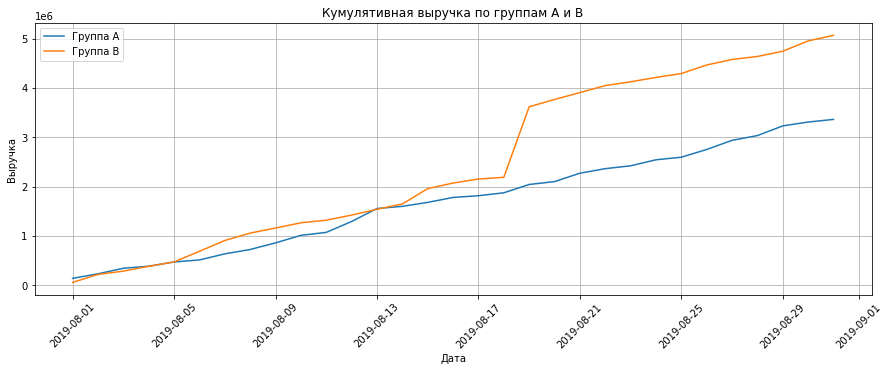

In [ ]:
datesGroups = orders[['date', 'group']].drop_duplicates()

ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(15,5))
plt.grid()

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='Группа A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='Группа B')

plt.title('Кумулятивная выручка по группам A и B')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.xticks(rotation=45)
plt.legend()

plt.show()

**Вывод:**<br/>
- Согласно графику группа B стабильно показывает большую выручку, чем группа А.
- В середине теста (19 августа) сегмент B ещё сильнее вырвался вперёд и продолжал лидировать весь остаток теста.

**Предположение:**<br/>
- Возможно в этот день был проведён заказ с аномально большой выручкой.

### График кумулятивного среднего чека по группам

Построим график кумулятивного среднего чека по группам и датам

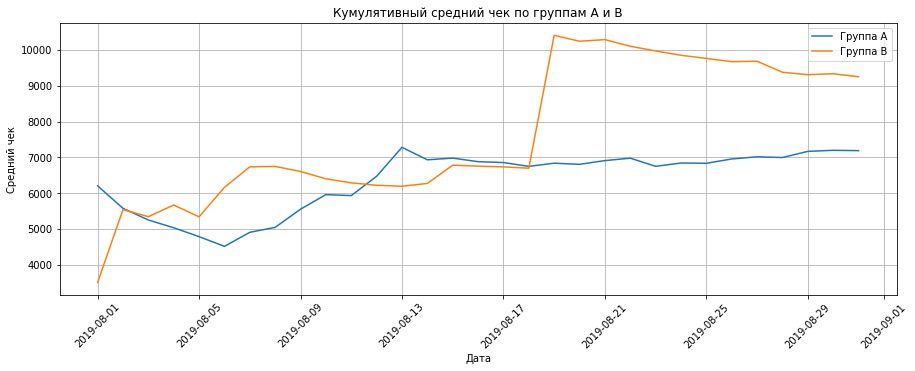

In [ ]:
plt.figure(figsize=(15,5))
plt.grid()

plt.plot(cumulativeRevenueA['date'],
         cumulativeRevenueA['revenue'] / cumulativeRevenueA['orders'],
         label='Группа A')

plt.plot(cumulativeRevenueB['date'],
         cumulativeRevenueB['revenue'] / cumulativeRevenueB['orders'],
         label='Группа B')

plt.title('Кумулятивный средний чек по группам A и B')
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.xticks(rotation=45)
plt.legend()

plt.show()

**Вывод:**<br/>
- Средний чек группы B большую часть времени выше среднего чека группы A.
- 12-14 августа наблюдается небольшой и не продолжительный пик, когда средний чек группы A выше.
- 18-19 августа так-же произошел аномальный скачек графика и средний чек группы B вырос практически в 1,5 раза.
- После 19 августа средний чек группы B начал плавное снижение.

**Предположение:**<br/>
- Всё указывает на то, что во второй половине теста имеет место быть аномально большой заказ.

### График относительного изменения кумулятивного среднего чека группы B к группе A

Построим график относительного изменения кумулятивного среднего чека группы B к группе A.

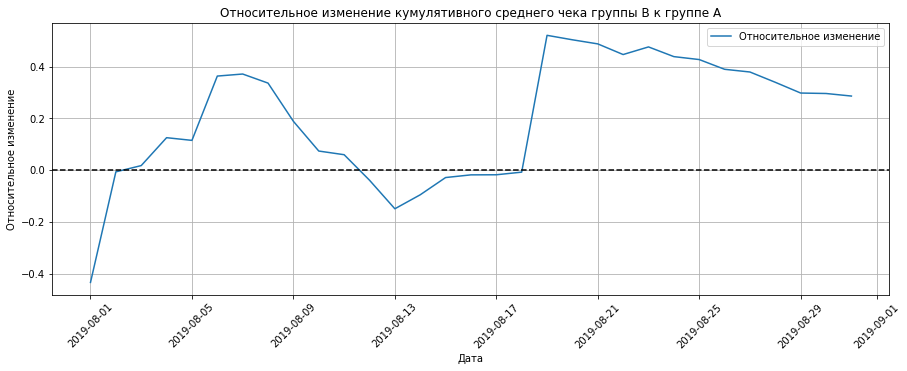

In [ ]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(
    cumulativeRevenueB,
    how='left',
    left_on='date',
    right_on='date',
    suffixes=['A', 'B']
)

plt.figure(figsize=(15,5))
plt.grid()

plt.plot(
    mergedCumulativeRevenue['date'],
    (mergedCumulativeRevenue['revenueB'] / mergedCumulativeRevenue['ordersB']) /
    (mergedCumulativeRevenue['revenueA'] / mergedCumulativeRevenue['ordersA']) - 1,
    label='Относительное изменение'
)

plt.axhline(y=0, color='black', linestyle='--')


plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Относительное изменение')
plt.xticks(rotation=45)
plt.legend()

plt.show()

**Вывод:**<br/>
- На графике наблюдаются резкие колебания
- Наблюдается подъем с 1 по 8 августа и с 13 по 18 августа
- Резкий спад с 9 по 13 августа и плавное падение с 19 августа и до конца теста

**Предположение:**<br/>
- Видимо действительно 19 августа были совершены аномальные заказы.

### График кумулятивного среднего количества заказов на посетителя по группам

Построим график кумулятивного среднего количества заказов на посетителя по группам

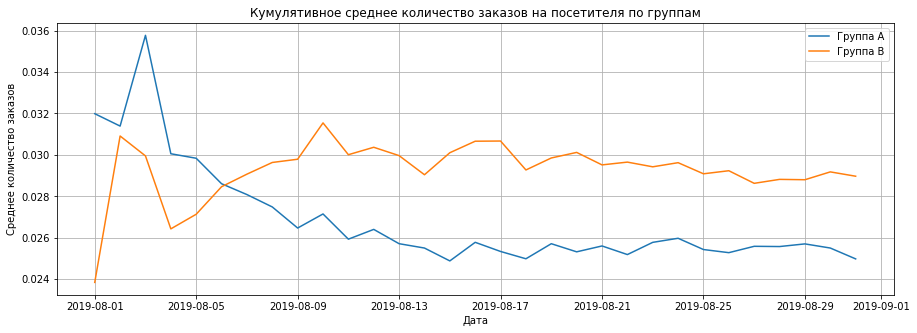

In [ ]:
cumulativeData['conversion'] = cumulativeData['orders'] / cumulativeData['visitors']

cumulativeDataA = cumulativeData[cumulativeData['group'] == 'A']
cumulativeDataB = cumulativeData[cumulativeData['group'] == 'B']

plt.figure(figsize=(15,5))
plt.grid()

plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='Группа A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='Группа B')

plt.title('Кумулятивное среднее количество заказов на посетителя по группам')
plt.xlabel('Дата')
plt.ylabel('Среднее количество заказов')
plt.legend()

plt.show()

**Вывод:**<br/>
- В начале теста сегмент A имел большее кумулятивное среднее количество заказов, но постепенно сегмент B вырвался вперёд и стабильно показывал большую конверсию до конца теста.

### График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

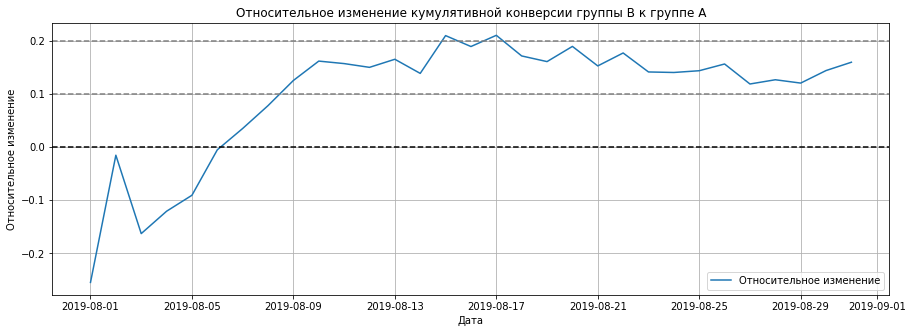

In [ ]:
mergedCumulativeConversions = cumulativeDataA[['date', 'conversion']].merge(
    cumulativeDataB[['date', 'conversion']],
    how='left',
    left_on='date',
    right_on='date',
    suffixes=['A', 'B']
)

plt.figure(figsize=(15,5))
plt.grid()

plt.plot(
    mergedCumulativeConversions['date'],
    mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1,
    label='Относительное изменение'
)

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')

plt.title('Относительное изменение кумулятивной конверсии группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Относительное изменение')
plt.legend()  # Добавляем легенду

plt.show()

**Вывод:**<br/>
- Почти с самого начала теста группа B лидирует по метрике: в середине теста был прирост в 20% относительно группы A, затем пошёл плавный отностельной конверсии спад до 10-14%.

### Точечный график количества заказов по пользователям

Cтроим точечный график количества заказов по пользователям

     visitor_id  orders
908  3967698036       3
55    249864742       3
478  2108163459       3
687  2988190573       3
890  3908431265       3
138   611059232       3
632  2742574263       3
157   678354126       2
323  1404560065       2
452  1985475298       2


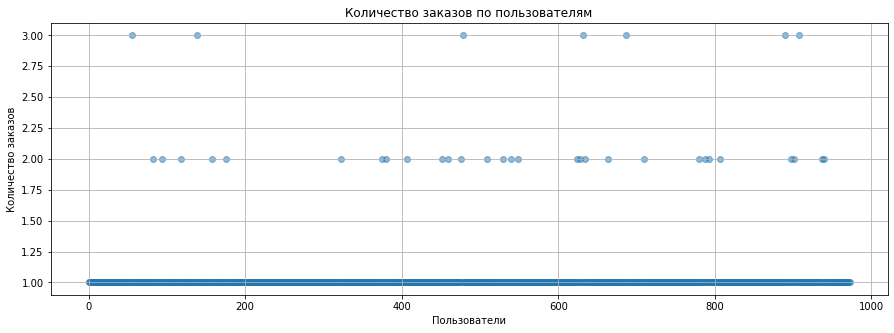

In [ ]:
ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)

# Выводим топ-10 пользователей по количеству заказов
ordersByUsers.columns = ['visitor_id', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10))

# Создаем серию из чисел от 0 до количества наблюдений в ordersByUsers для оси X
x_values = pd.Series(range(0, len(ordersByUsers)))

plt.figure(figsize=(15,5))
plt.grid()
plt.title('Количество заказов по пользователям')
plt.xlabel('Пользователи')
plt.ylabel('Количество заказов')
plt.scatter(x_values, ordersByUsers['orders'], alpha=0.5)

plt.show()

**Вывод:**<br/>
- Из графика следует, что подавляющее большинство пользователй не совершает более 2 заказов

### 95-й и 99-й перцентили количества заказов на пользователя

Посчитаем 95-й и 99-й перцентили количества заказов на пользователя
Выберем границу для определения аномальных пользователей

In [ ]:
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[1. 2.]


**Вывод:**<br/>
- Лишь немногие пользователи (5%) сделали более 1 заказа
- Очень небольшое (аномаьное) количество пользователей (1%) сделали более 2 заказов

### Точечный график стоимостей заказов

Построим точечный график стоимостей заказов

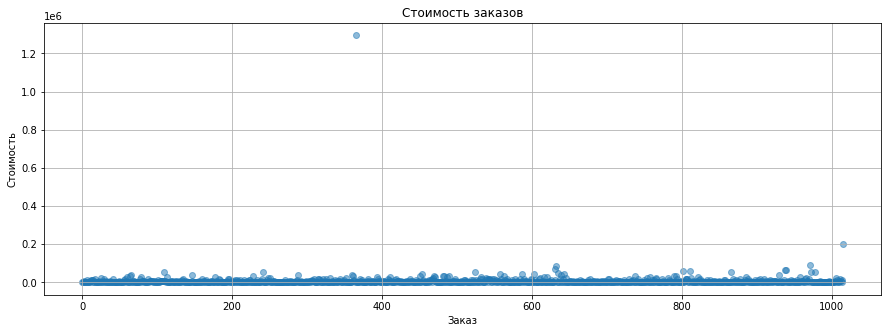

In [ ]:
x_values = pd.Series(range(0, len(orders['revenue'])))

plt.figure(figsize=(15,5))
plt.grid()
plt.title('Стоимость заказов')
plt.xlabel('Заказ')
plt.ylabel('Стоимость')
plt.scatter(x_values, orders['revenue'], alpha=0.5)

plt.show()

Построим точечный график стоимостей заказов без выбросов

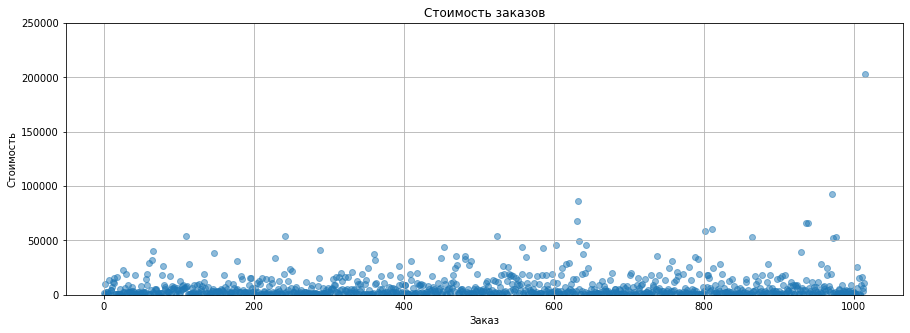

In [ ]:
x_values = pd.Series(range(0, len(orders['revenue'])))

plt.figure(figsize=(15,5))
plt.grid()
plt.title('Стоимость заказов')
plt.xlabel('Заказ')
plt.ylabel('Стоимость')
plt.scatter(x_values, orders['revenue'], alpha=0.5)
plt.ylim(0,250000)

plt.show()

**Вывод:**<br/>
- В основной массе у заказов сумма не превышает 25 тысяч.
- Есть единичные аномальные заказы на сумму 200 тысяч и 1,2 млн.

### 95-й и 99-й перцентили стоимости заказов

Посчитаем 95-й и 99-й перцентили стоимости заказов

In [ ]:
print(np.percentile(orders['revenue'], [95, 99]))

[26785. 53904.]


**Вывод:**<br/>
- Лишь немногие заказы (5%) были сделаны на сумму более 26785
- Очень небольшое количество аномальных заказов (1%) были сделаны на сумму более 53904

### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

Посчитаем статистическую значимость различий в среднем числе заказов на пользователя и среднем чеке между группами по «сырым» данным — без удаления аномальных пользователей.

Сформулируем гипотезы.
- **H0:** различий в среднем количестве заказов между группами нет.
- **H1:** различия в среднем между группами есть.

In [ ]:
# Создаем таблицу с данными о ежедневных посещениях для группы A
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']  # Переименовываем столбцы

# Вычисляем кумулятивные посещения для группы A
visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']  # Переименовываем столбцы

# Создаем таблицу с данными о ежедневных посещениях для группы B
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']  # Переименовываем столбцы

# Вычисляем кумулятивные посещения для группы B
visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']  # Переименовываем столбцы

# Создаем таблицу с данными о ежедневных заказах и выручке для группы A
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})  # Количество уникальных заказов и сумма выручки
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']  # Переименовываем столбцы

# Вычисляем кумулятивные заказы и выручку для группы A
ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])  # Сортируем по дате для удобства анализа
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]  # Переименовываем столбцы

# Создаем таблицу с данными о ежедневных заказах и выручке для группы B
ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})  # Количество уникальных заказов и сумма выручки
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']  # Переименовываем столбцы

# Вычисляем кумулятивные заказы и выручку для группы B
ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])  # Сортируем по дате для удобства анализа
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]  # Переименовываем столбцы

# Объединяем все таблицы в один DataFrame по дате (date), чтобы получить полную сводку данных
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

# Выводим первые 5 строк объединенного DataFrame для проверки результата
display(data.head(5))

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


Посчитаем статистическую значимость различия в среднем количестве заказов между группами.

Создадим переменные `ordersByUsersA` и `ordersByUsersB` со столбцами `['userId', 'orders']`. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

In [ ]:
# Группируем данные по пользователям группы A, чтобы посчитать количество уникальных заказов для каждого пользователя
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})  # Количество уникальных заказов для каждого пользователя
)
ordersByUsersA.columns = ['visitor_id', 'orders']  # Переименовываем столбцы

# Группируем данные по пользователям группы B аналогично, подсчитывая уникальные заказы
ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})  # Количество уникальных заказов для каждого пользователя
)
ordersByUsersB.columns = ['visitor_id', 'orders']  # Переименовываем столбцы

# Формируем выборку заказов для группы A
sampleA = pd.concat(
    [
        ordersByUsersA['orders'],  # Количество заказов у пользователей, которые сделали хотя бы один заказ
        pd.Series(
            0,  # Заполняем 0 для посетителей, которые не сделали ни одного заказа
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),  # Индексы для нулей: разница между общим числом посетителей и числом заказавших пользователей
            name='orders',
        ),
    ],
    axis=0,
)

# Формируем выборку заказов для группы B (аналогично)
sampleB = pd.concat(
    [
        ordersByUsersB['orders'],  # Количество заказов у пользователей, которые сделали хотя бы один заказ
        pd.Series(
            0,  # Заполняем 0 для посетителей, которые не сделали ни одного заказа
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),  # Индексы для нулей: разница между общим числом посетителей и числом заказавших пользователей
            name='orders',
        ),
    ],
    axis=0,
)

# Выводим p-значение для теста Манна-Уитни на проверку разницы между выборками sampleA и sampleB
print("p-value: " "{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

# Выводим относительное изменение среднего числа заказов в группе B по сравнению с группой A
print("Относительное изменение: " "{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

p-value: 0.011
Относительное изменение: 0.160


**Вывод:**<br/>
- По «сырым» данным различия в среднем числе заказов групп A и B есть.
- `p-value = 0.011` меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, ОТВЕРГАЕМ.
- Относительный выигрышь группы "B" равен 16%.

### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

Проверим статистическую значимость различий в среднем чеке между сегментами.
- **H0:** различий в среднем чеке между группами нет.
- **H1:** различия в среднем чеке между группами есть.

Чтобы рассчитать статистическую значимость различий в среднем чеке, передадим критерию `mannwhitneyu()` данные о выручке с заказов.

А ещё найдём относительные различия в среднем чеке между группами:

In [ ]:
print("p-value: " '{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print("Относительное изменение: " '{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p-value: 0.829
Относительное изменение: 0.287


**Вывод:**<br/>
- По «сырым» данным различий в среднем чеке заказов между группами A и B нет.
- `p-value = 0.829` значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет.
- Наблюдаемое различие средних чеков группы B по отношению к группе A в 28,7% не является статистически значимым.

### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

На предыдущих шагах (3.7, 3.9) мы приняли за аномальных пользователей тех, кто севершил 2 и более заказаов или тех, кто совершил заказ дороже 53 904. Сделаем срезы пользователей с числом заказов больше 1 — `usersWithManyOrders` и пользователей, совершивших заказы дороже 53 904 — `usersWithExpensiveOrders`. Объединим их в таблице `abnormalUsers`.

Узнаем, сколько всего аномальных пользователей атрибутом `shape`.

In [ ]:
# Создаем список пользователей с более чем 1 заказами в каждой из групп (A и B)
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 1]['visitor_id'],  # Пользователи группы A с > 1 заказами
        ordersByUsersB[ordersByUsersB['orders'] > 1]['visitor_id'],  # Пользователи группы B с > 1 заказами
    ],
    axis=0,
)

# Создаем список пользователей, чьи заказы принесли больше 53 904 в выручке
usersWithExpensiveOrders = orders[orders['revenue'] > 53904]['visitor_id']

# Создаем объединенный список "аномальных" пользователей (с большим количеством заказов или дорогими заказами)
# Объединяем два списка, удаляем дубликаты и сортируем пользователей
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()  # Убираем дубликаты пользователей
    .sort_values()  # Сортируем пользователей по их ID (или другому критерию)
)

print(abnormalUsers.head())
print(len(abnormalUsers))

1099    148427295
33      249864742
36      366673373
51      406208401
67      522292794
Name: visitor_id, dtype: int64
45


Всего 45 аномальных пользователей.

Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в среднем количестве заказов между группами теста по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста:

In [ ]:
# Формируем отфильтрованную выборку для группы A, исключая "аномальных" пользователей
# Оставляем только тех пользователей, которые не входят в список abnormalUsers
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))  # Исключаем аномальных пользователей
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),  # Заполняем 0 для посетителей без заказов
            name='orders',
        ),
    ],
    axis=0,
)

# Формируем отфильтрованную выборку для группы B, исключая "аномальных" пользователей
# Оставляем только тех пользователей, которые не входят в список abnormalUsers
sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))  # Исключаем аномальных пользователей
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),  # Заполняем 0 для посетителей без заказов
            name='orders',
        ),
    ],
    axis=0,
)

Применим статистический критерий Манна-Уитни к полученным выборкам:

Сформулируем гипотезы.
- **H0**: статистически значимых различий в среднем количестве заказов между группами по очищенным данным нет.
- **H1**: статистически значимые различия в среднем между группами есть.

In [ ]:
print("p-value: " '{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print("Относительное изменение: " '{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

p-value: 0.008
Относительное изменение: 0.188


**Вывод:**<br/>
- По «очищенным» данным различия в среднем числе заказов групп A и B есть.
- `p-value = 0.008` меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем количестве заказов между группами по очищенным данным нет - отвергаем.
- Относительный выигрышь группы "B" равен 18,8%.

### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

Сформулируем гипотезы.
- **H0:** статистически значимых различий в средних чеках между группами нет
- **H1:** статистически значимые различия в среднем между группами есть.

In [ ]:
print(
    "p-value: " '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
   "Относительное изменение: " "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

p-value: 0.969
Относительное изменение: 0.002


**Вывод:**<br/>
- По «очищенным» данным различий в среднем чеке заказов групп A и B нет.
- `p-value = 0.969` больше 0.05. Значит, нулевую гипотезу о том, что различий в средних чеках между группами нет - не отвергаем.
- Средний чек группы B оказался на 0,2% ниже среднего чека группы A.

### Решение по результатам теста

**Выводы:**<br/>
- Есть статистически значимое различие по конверсии между группами как по сырым данным, так и после фильтрации аномалий. Относительный выигрышь группы "B" над "A" по "сырым" данным равен 16%, по "очищенным" данным выигрышь равен 18,8%.
- Хотя группа B имеет средний чек, превышающий аналогичный показатель группы A, это отличие статистически не значимо. Таким образом, увеличение числа заказов в группе B не сопровождается таким же увеличением среднего чека. По "сырым" данным средний чек группы "B" на 28,7% выше среднего чека группы "A", при этом по "очищенным" данным средний чек группы "B" ниже на 0,2%.

Увеличение конверсии в группе B по сравнению с группой A сохраняется даже после очистки данных, что делает результат достоверным и устойчивым. Поскольку конверсия напрямую влияет на выручку, значимый рост конверсии в группе B приводит к увеличению выручки, несмотря на то, что средний чек остался практически неизменным.

**Решение по результатам теста:**<br/>
Остановить тест и зафиксировать победу группы В.

## Общий вывод

В ходе исследования по приоритизации гипотез и проведению A/B-тестирования были пройдены шаги и получены следующие данные:

1) **Подготовка данных**
   - Загружены и проверены данные `hypothesis`, `orders`, `visitors`, столбцы приведены к `snake_case` и типам данных.
   - Пропусков и дубликатов не обнаружено; данные за период 01.08.2019 - 31.08.2019.

2) **Приоритизация гипотез**
   - Применены фреймворки `ICE` и `RICE`.
   - **ICE**: лидеры гипотезы 8, 0, 7; **RICE**: 7, 2, 0. Гипотеза 7 вышла на первое место по `RICE`, так как учитывает охват (Reach), важный фактор для значимости гипотезы.

3) **Анализ A/B-теста**
   - **Выручка по группам**: Группа B стабильно выше группы A; с 19 августа разрыв усилился.
   - **Средний чек по группам**: В группе B чек выше, но с колебаниями, особенно 18-19 августа.
   - **Изменение среднего чека B к A**: Резкие скачки, особенно с 1 по 8 августа и с 13 по 18 августа.
   - **Среднее число заказов**: Группа B постепенно обогнала A и сохраняла преимущество до конца теста.
   - **Изменение среднего числа заказов B к A**: B стабильно выше, прирост до 20%, к концу теста 10-14%.
   - **График заказов по пользователям**: Подавляющее большинство пользователей делает до 2 заказов.
   - **Анализ аномалий по заказам и их стоимости**: 95% пользователей сделали не более 1 заказов, стоимость большинства не превышала 25,000, отдельные — до 1,2 млн.

4) **Статистическая значимость различий**
   - **Среднее число заказов на пользователя**:
      - **Сырые данные**: p-value = 0.011 (<0.05), значимое отличие, прирост B на 16%.
      - **Очищенные данные**: p-value = 0.008 (<0.05), значимое отличие, прирост B на 18,8%.
   - **Средний чек**:
      - **Сырые данные**: p-value = 0.829 (>0.05), значимых отличий нет. Средний чек B выше на 28,7%.
      - **Очищенные данные**: p-value = 0.969 (>0.05), значимых отличий нет, средний чек B на 0,2% ниже A.

5) **Решение по результатам теста**:
   - Тест можно завершить, зафиксировав победу группы B.